In [25]:
library(tidyverse)
library(ggrepel)
library(ggthemes)
library(readxl)
library(ggsci)

#reading in data
food_consumption <- read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-18/food_consumption.csv')
global_emissions = read_excel('CO2_Emissions.xls', sheet = 1)
meta_data_global_emissions = read_excel('CO2_Emissions.xls', sheet = 2)

Loading required package: viridisLite

Parsed with column specification:
cols(
  country = col_character(),
  food_category = col_character(),
  consumption = col_double(),
  co2_emmission = col_double()
)



In [2]:
head(food_consumption)

country,food_category,consumption,co2_emmission
<chr>,<chr>,<dbl>,<dbl>
Argentina,Pork,10.51,37.20
Argentina,Poultry,38.66,41.53
Argentina,Beef,55.48,1712.00
Argentina,Lamb & Goat,1.56,54.63
Argentina,Fish,4.36,6.96
Argentina,Eggs,11.39,10.46


# Which countries had the greatest proportion of animal product consumption per kg/person/year?

In [3]:
animal_products = c('Pork', 'Poultry', 'Beef', 'Lamb & Goat','Fish','Milk - inc. cheese', 'Eggs')
non_animal_products = c('Wheat and Wheat Products', 'Rice','Soybeans','Nuts inc. Peanut Butter')

animal_product_sum = food_consumption %>%
    filter(food_category %in% animal_products) %>%
    group_by(country) %>% 
    summarize(animal_prod_country_sum = sum(consumption))

non_animal_product_sum = food_consumption %>%
    filter(food_category %in% non_animal_products) %>%
    group_by(country) %>% 
    summarize(non_animal_prod_country_sum = sum(consumption))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [4]:
#getting Percent_Difference
percent_difference = (abs(animal_product_sum$animal_prod_country_sum - non_animal_product_sum$non_animal_prod_country_sum)/((animal_product_sum$animal_prod_country_sum + non_animal_product_sum$non_animal_prod_country_sum)/2)) * 100
#adding country names to df
final_df = data.frame(cbind(non_animal_product_sum$country, percent_difference))
#assigning column names
colnames(final_df) = c('Country', 'Percent_Difference')
#need to make proporition col a numeric
final_df$Percent_Difference = as.numeric(final_df$Percent_Difference)

#Want to change this df so that I can facet wrap by countries that eat greater proportion of animal or non-animal prod
final_df = final_df %>% 
    mutate(Greater_Animal_Category = ifelse(Percent_Difference < 100, 'Non-Animal','Animal'))
#putting this new col into a factor to change it's position in the figure
final_df$Greater_Animal_Category = factor(final_df$Greater_Animal_Category, levels = c('Non-Animal','Animal'))

head(final_df)

,Country,Percent_Difference,Greater_Animal_Category
,<chr>,<dbl>,<fct>
1,Albania,86.786928,Non-Animal
2,Algeria,9.014842,Non-Animal
3,Angola,21.984654,Non-Animal
4,Argentina,95.326145,Non-Animal
5,Armenia,66.050944,Non-Animal
6,Australia,122.243007,Animal


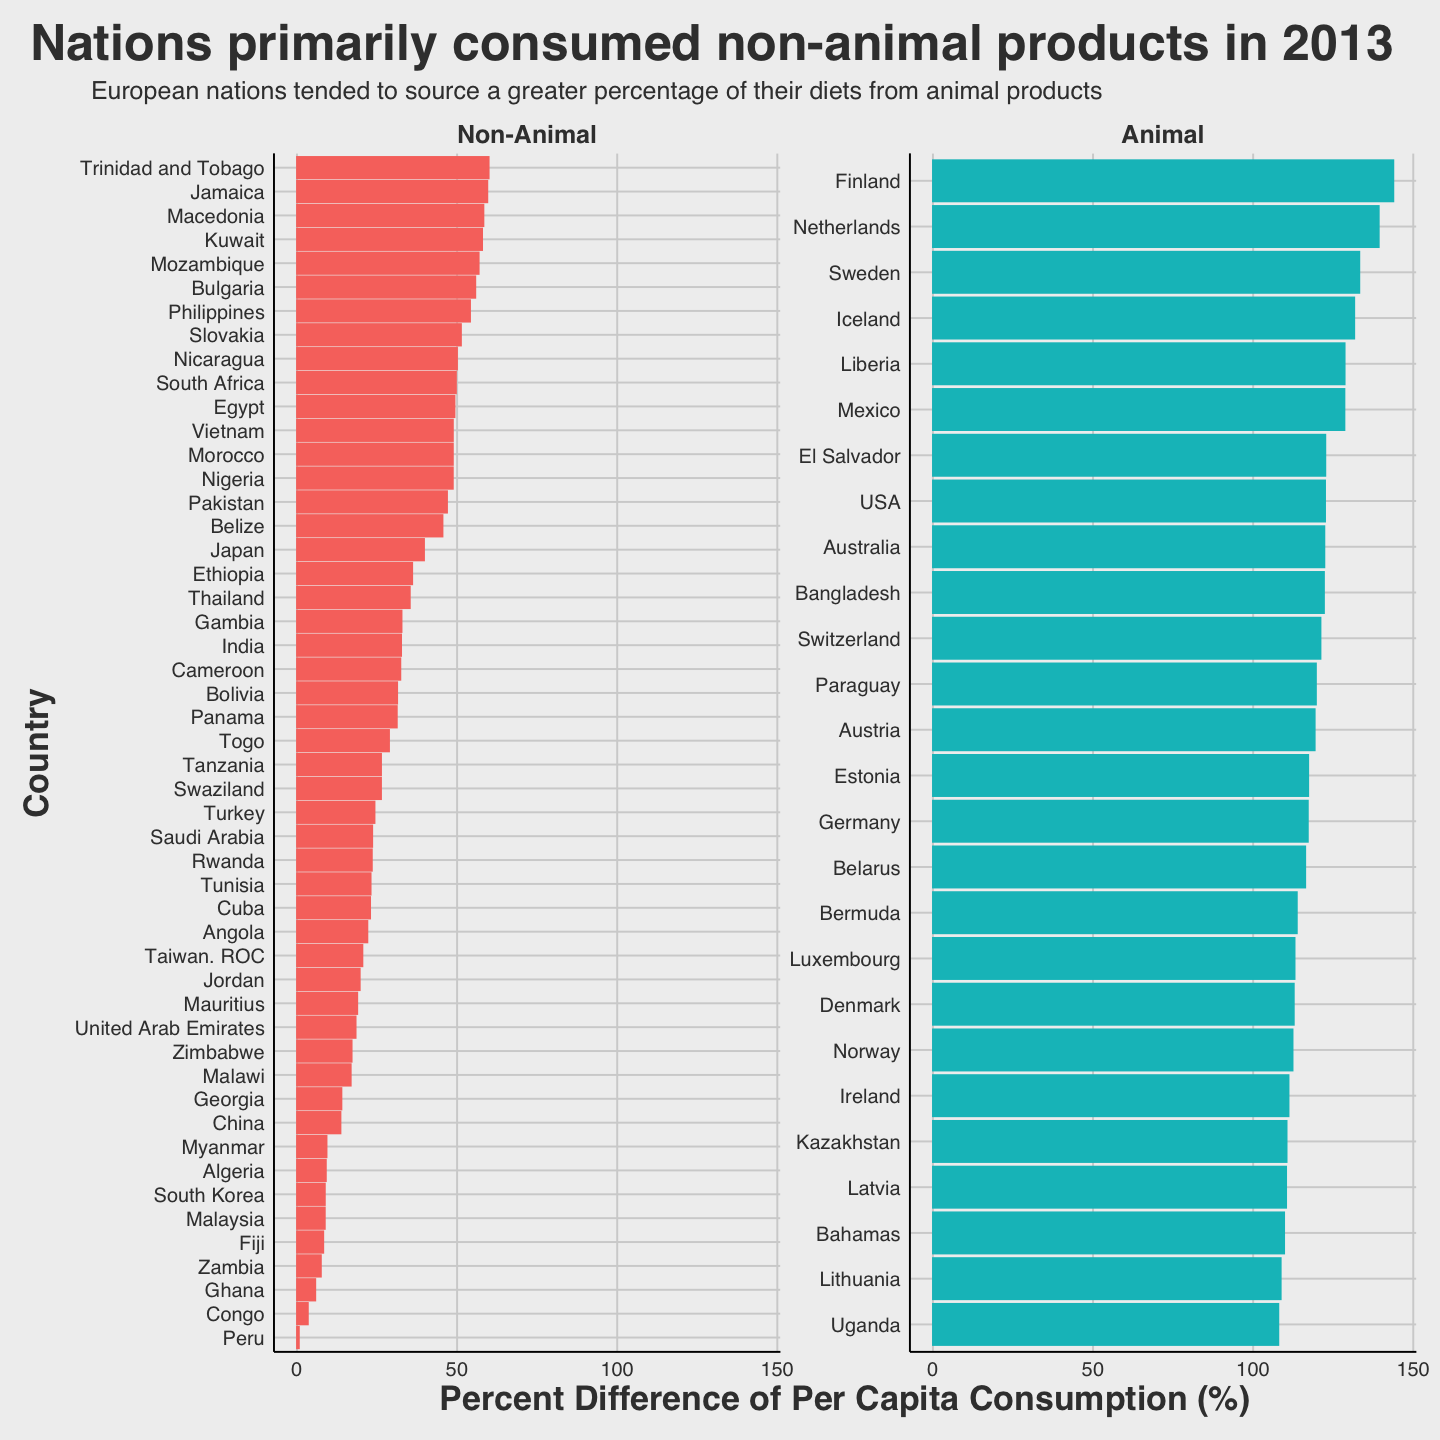

In [5]:
options(repr.plot.width = 12, repr.plot.height = 12)
ggplot(data = final_df %>%
      filter(Percent_Difference < 60 | Percent_Difference > 105)) + #removing countries just to make visualization nicer
  geom_col(aes(x = Percent_Difference, y = reorder(Country, Percent_Difference), color = Greater_Animal_Category, fill = Greater_Animal_Category)) + 
  facet_wrap(~Greater_Animal_Category, scales = 'free_y') +

  theme_fivethirtyeight() + 
  theme(axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        axis.title.y = element_text(margin = margin(r = 12)), #changing y axis title
        legend.position = "none", #removing legend
        legend.text = element_text(size = 12), #changes legend text
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold"),
        plot.title = element_text(hjust = 1.1, size = 30), #changing plot title
        plot.subtitle = element_text(hjust = -1.4, size = 15), #changing plot subtitle
        plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm")) + #changes size of facet y axis 

   labs(title = 'Nations primarily consumed non-animal products in 2013', 
       subtitle = "European nations tended to source a greater percentage of their diets from animal products",
        x = 'Percent Difference of Per Capita Consumption (%)', y = ('Country')) 


# Which animal product causes the greatest CO2 emissions?

In [6]:
mutated_food_consumption = food_consumption %>%
    group_by(food_category) %>%
    mutate(median_co2_emmissions = median(co2_emmission), Animal_Category = ifelse(food_category %in% animal_products, 'Animal', 'Non-Animal'))

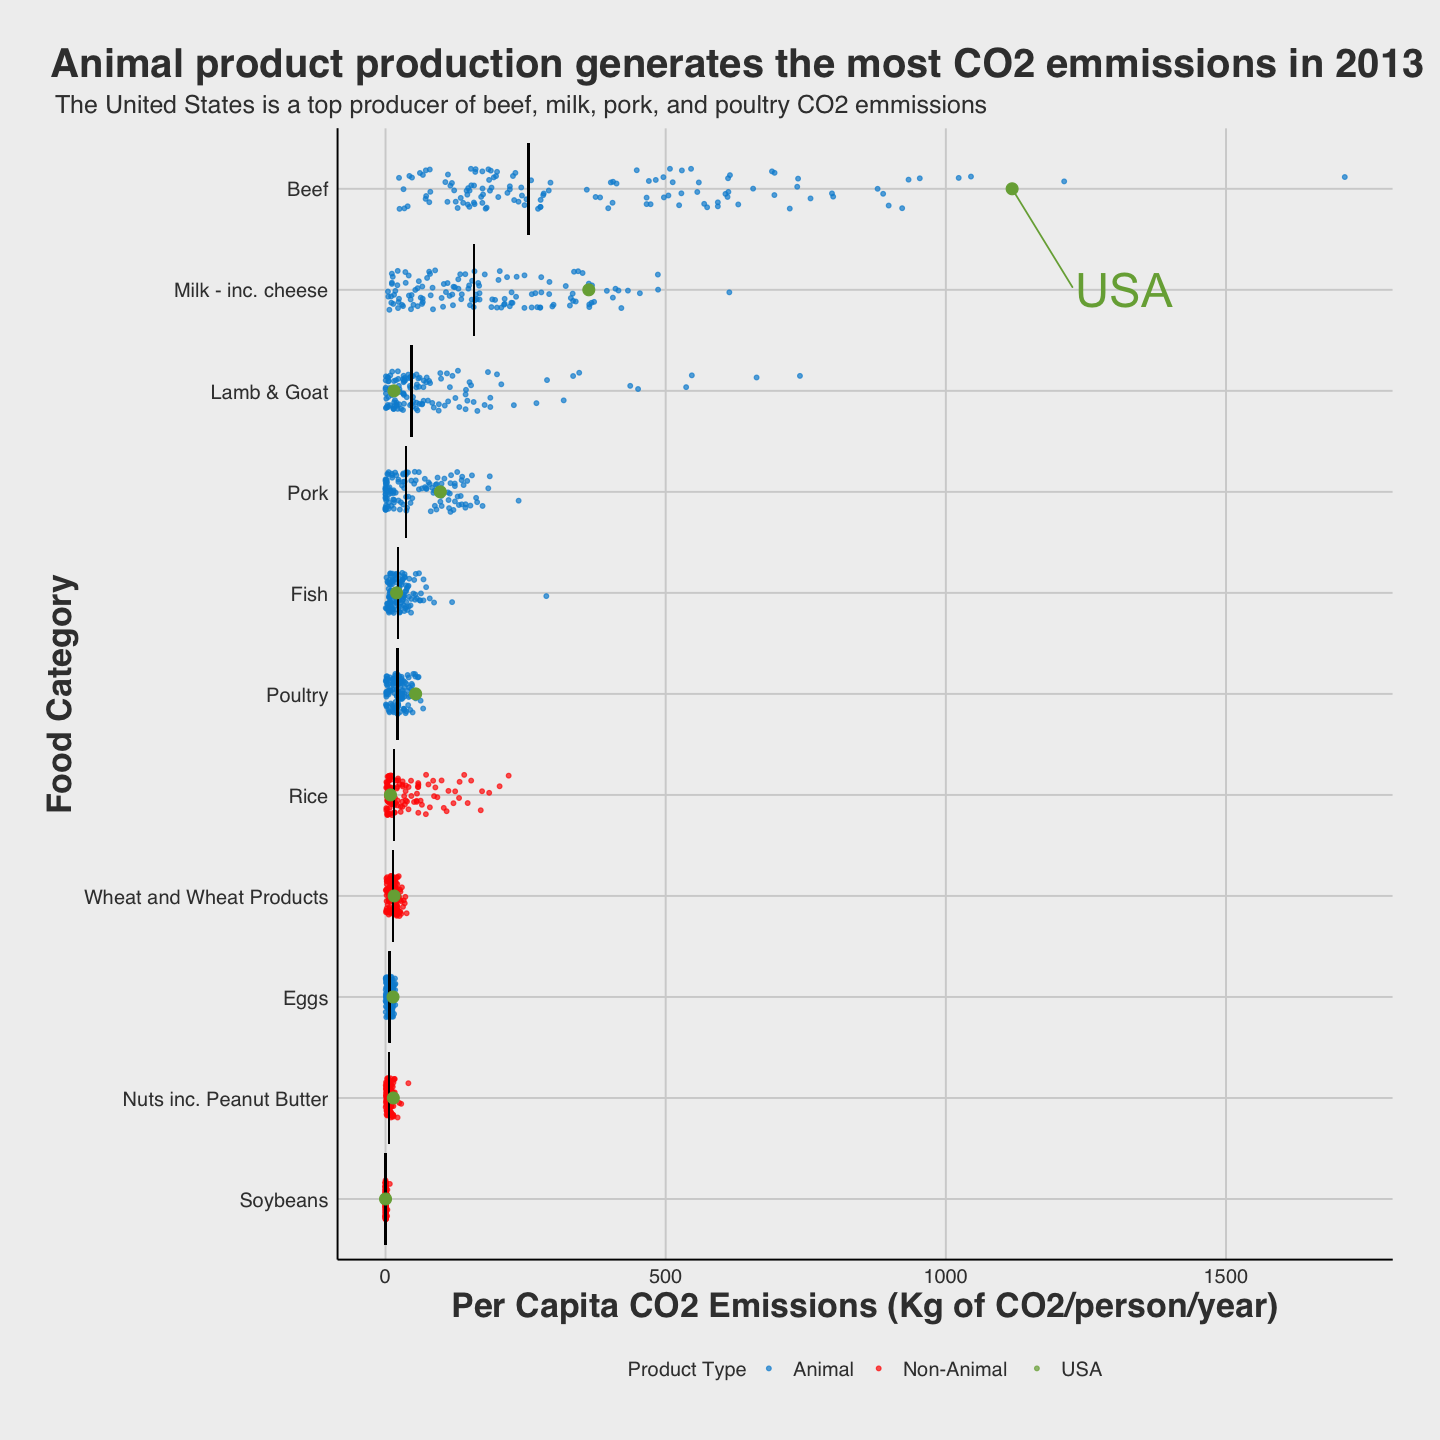

In [7]:
ggplot(data = mutated_food_consumption, aes(y = reorder(food_category, median_co2_emmissions), x = co2_emmission)) + 
  geom_point(aes(color = Animal_Category),
             position = position_jitter(h = 0.2, w = 0), alpha = 0.7, size = 1) +
  geom_crossbar(aes(x = median_co2_emmissions, y = food_category, xmin = median_co2_emmissions, 
                    xmax = median_co2_emmissions), size = 0.2) + 
  geom_point(data = mutated_food_consumption %>% 
             filter(country == 'USA'), show.legend = FALSE, aes(color = country), size = 3) + 
  geom_text_repel(data = mutated_food_consumption %>% 
                  filter(country == 'USA'& food_category == 'Beef'), #labeling a green point for USA
    nudge_x = 200,
    nudge_y = -1,
    segment.size = 0.5,
    size = 10, 
    show.legend = FALSE, 
    aes(label = country, color = country)) +

  theme_fivethirtyeight() + 

    theme(axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.text = element_text(size = 12), #changes legend text
        plot.margin = unit(c(1,1,1,1), "cm"),
        plot.title = element_text(hjust = 0.9, size = 24), #changing plot title
        plot.subtitle = element_text(hjust = -2.3, size = 15)) + #changing plot subtitle

  scale_color_fivethirtyeight() +

  labs(title = 'Animal product production generates the most CO2 emmissions in 2013',
       subtitle = "The United States is a top producer of beef, milk, pork, and poultry CO2 emmissions",
       x = "Per Capita CO2 Emissions (Kg of CO2/person/year)", y = 'Food Category', color = 'Product Type',
      label = 'United States')

# What about CO2 emissions overall stratified by income?

Country.  Year   Value  Region Income Group
Albania   1960    --
Albania   1961    --

In [8]:
#changing name of North Korea bc it was giving me issues 
for (i in 1:length(global_emissions$`Country Name`)){
    if(global_emissions$`Country Name`[i] == 'Korea, Dem. People’s Rep.'){
        global_emissions$`Country Name`[i] = 'North Korea'
    }
}

#making cols into factors
global_emissions$`Country Name` = factor(global_emissions$`Country Name`)
global_emissions$`Country Code` = factor(global_emissions$`Country Code`)

#pivoting data
global_emissions = global_emissions %>%
    pivot_longer(cols = `1960`:`2016`, values_drop_na = TRUE)

#changing col names
colnames(global_emissions) = c('Country Name','Country Code','Year', 'CO2 Emissions')
head(global_emissions)

Country Name,Country Code,Year,CO2 Emissions
<fct>,<fct>,<chr>,<dbl>
Aruba,ABW,1960,204.6204
Aruba,ABW,1961,208.8228
Aruba,ABW,1962,226.1181
Aruba,ABW,1963,214.8004
Aruba,ABW,1964,207.6158
Aruba,ABW,1965,185.2040


In [9]:
#joining the two global emissions dataframes
global_emissions_df = global_emissions %>%
    inner_join(meta_data_global_emissions) %>%
    select(`Country Name`, `Country Code`, Year, `CO2 Emissions`, Region, IncomeGroup)

#putting into a factor
global_emissions_df$IncomeGroup = factor(global_emissions_df$IncomeGroup, levels = c('Low income', 
                                                                                     'Lower middle income',
                                                                                    'Upper middle income',
                                                                                    'High income'))

head(global_emissions_df)

Joining, by = "Country Code"



Country Name,Country Code,Year,CO2 Emissions,Region,IncomeGroup
<fct>,<chr>,<chr>,<dbl>,<chr>,<fct>
Aruba,ABW,1960,204.6204,Latin America & Caribbean,High income
Aruba,ABW,1961,208.8228,Latin America & Caribbean,High income
Aruba,ABW,1962,226.1181,Latin America & Caribbean,High income
Aruba,ABW,1963,214.8004,Latin America & Caribbean,High income
Aruba,ABW,1964,207.6158,Latin America & Caribbean,High income
Aruba,ABW,1965,185.2040,Latin America & Caribbean,High income


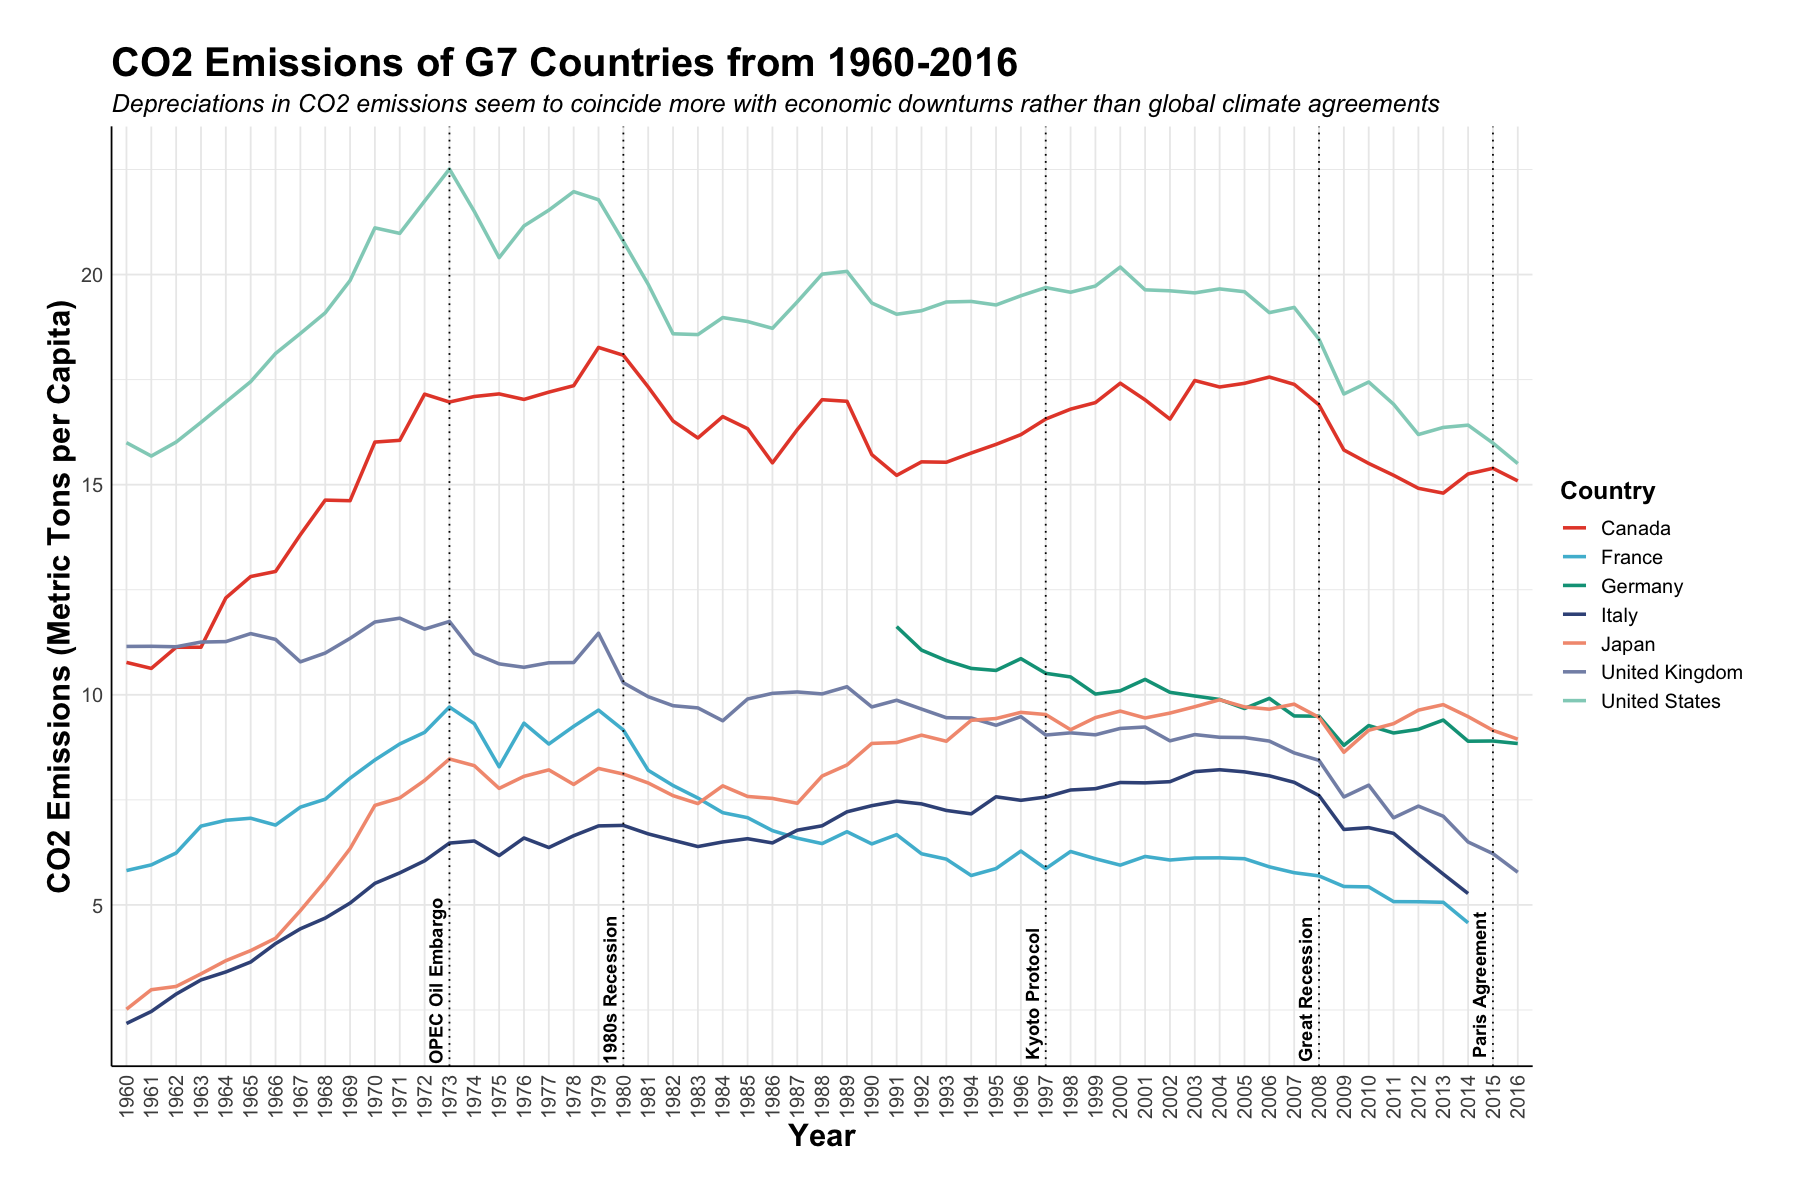

In [100]:
#G7 countries
G7_countries = c("Japan", "United States", "France", "Germany", "Italy", "Canada", "United Kingdom")

options(repr.plot.width = 15, repr.plot.height = 10)
ggplot() + 
  geom_line(data = global_emissions_df %>%
      filter(`Country Name` %in% G7_countries), aes(x = Year, y = `CO2 Emissions`, group = `Country Code`, 
                                                    color = `Country Name`), size = 1) + 
  geom_vline(xintercept = "1973", linetype = "dotted") + # OPEC oil embargo
  geom_text(aes(x = "1973", label = "OPEC Oil Embargo\n", y = 3.2), angle = 90, fontface = "bold") +
  geom_vline(xintercept = "1980", linetype = "dotted") + # Stagflation --> recession beginning in 1980
  geom_text(aes(x = "1980", label = "1980s Recession\n", y = 3), angle = 90, fontface = "bold") +
  geom_vline(xintercept = "1997", linetype = "dotted") + #Kyoto protocol (first legally binding treaty)
  geom_text(aes(x = "1997", label = "Kyoto Protocol\n", y = 2.9), angle = 90, fontface = "bold") +
  geom_vline(xintercept = "2008", linetype = "dotted") + #stock market crash --> Great Recession
  geom_text(aes(x = "2008", label = "Great Recession\n", y = 3), angle = 90, fontface = "bold") +
  geom_vline(xintercept = "2015", linetype = "dotted") + #Paris agreement
  geom_text(aes(x = "2015", label = "Paris Agreement\n", y = 3.1), angle = 90, fontface = "bold") +

  theme_minimal() + 
  scale_color_npg() + 

  theme(axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.text.x = element_text(angle = 90, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face= "bold", size = 15),
        legend.text = element_text(size = 12), #changes legend text
        plot.margin = unit(c(1,1,1,1), "cm"),
        plot.title = element_text(size = 24, face = "bold"), #changing plot title
        plot.subtitle = element_text(size = 15, face = "italic")) + #changing plot subtitle

  labs(title = 'CO2 Emissions of G7 Countries from 1960-2016',
       subtitle = "Depreciations in CO2 emissions seem to coincide more with economic downturns rather than global climate agreements",
       y = 'CO2 Emissions (Metric Tons per Capita)', color = 'Country')



# Ignore everything below this

In [19]:
regional_groups = c('ARB', "CEB", "CSS", "EAS", "ECS", "EMU", "EUU", "LCN", "MEA", "NAC", "SAS")
top_emitters_2016 = global_emissions_df %>%
    filter(`Country Code`!= regional_groups, Year == '2016') %>%
    arrange(-`CO2 Emissions`) %>%
    select(`Country Name`) %>%
    head(10)

bottom_emitters_2016 = global_emissions_df %>%
    filter(`Country Code`!= regional_groups, Year == '2016', IncomeGroup != 'NA') %>%
    arrange(`CO2 Emissions`) %>%
    select(`Country Name`) %>%
    head(10)

emitters_2016_df = global_emissions_df %>%
    filter(`Country Name` %in% top_emitters_2016$`Country Name` | `Country Name` %in% bottom_emitters_2016$`Country Name`) %>%
    mutate(emitter_group = ifelse(`CO2 Emissions` > 15, 'Top', 'Bottom'))


Warning message in `Country Code` != regional_groups:
“longer object length is not a multiple of shorter object length”
Warning message in `Country Code` != regional_groups:
“longer object length is not a multiple of shorter object length”


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



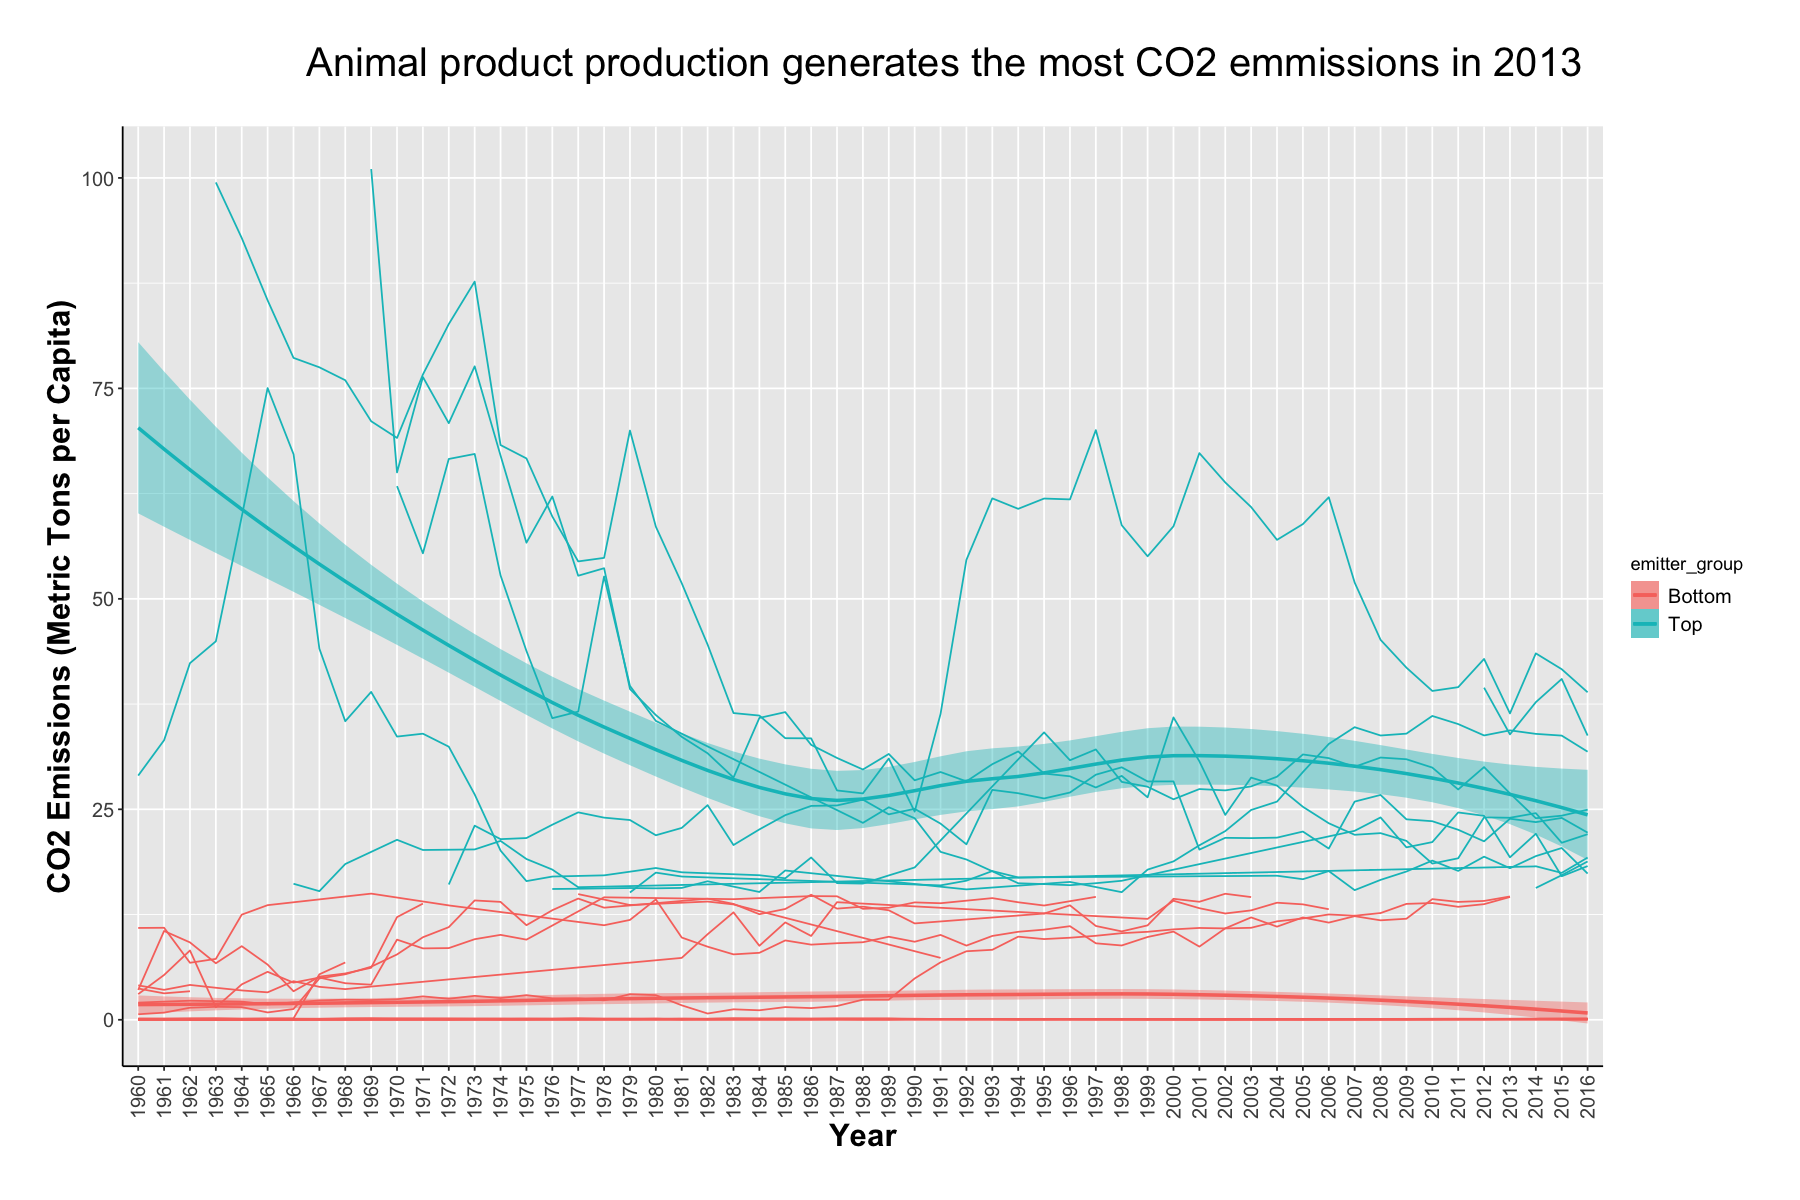

In [29]:
#who has the greatest emissions top 10 in 2016?
#y = reorder(Country, Proportion)
#do something with country name world
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot() + 
  geom_line(data = emitters_2016_df %>%
      filter(emitter_group == 'Top'),
            aes(x = Year, y = `CO2 Emissions`, group = `Country Name`, color = emitter_group)) + 
  geom_smooth(data = emitters_2016_df %>%
      filter(emitter_group == 'Top'),
            aes(x = Year, y = `CO2 Emissions`, group = 1, color = emitter_group, fill = emitter_group)) + 
  geom_line(data = emitters_2016_df %>%
     filter(emitter_group == 'Bottom'),
            aes(x = Year, y = `CO2 Emissions`, group = `Country Name`, color = emitter_group)) + 
  geom_smooth(data = emitters_2016_df %>%
      filter(emitter_group == 'Bottom'),
            aes(x = Year, y = `CO2 Emissions`, group = 1, color = emitter_group, fill = emitter_group)) + 

  #scale_y_log10() + 
   #facet_wrap(~emitter_group, ncol = 1, scales = 'free_y')+

  theme(axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.text.x = element_text(angle = 90, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.text = element_text(size = 12), #changes legend text
        plot.margin = unit(c(1,1,1,1), "cm"),
        plot.title = element_text(hjust = 0.9, size = 24), #changing plot title
        plot.subtitle = element_text(hjust = -2.3, size = 15)) + #changing plot subtitle
  
#   scale_color_viridis(discrete = TRUE) + 
#   scale_fill_viridis(discrete = TRUE) + 

  labs(title = 'Animal product production generates the most CO2 emmissions in 2013',
       subtitle = "The United States is a top producer of beef, milk, pork, and poultry CO2 emmissions",
       y = 'CO2 Emissions (Metric Tons per Capita)')

In [ ]:
all_regional_groups = c('ARB', "CEB", "CSS", "EAP", "EAR","ECA", "EAS", "ECS", "EMU", "EUU", "FCS", "HIC", "HPC", "IBD", "IBT",
                        "IDA", "IDB", "IDX", "LAC", "LIC","LCN", "LDC", "LMC", "LMY", "LTE", "MEA", "MNA", "NAC", "OED", "OSS", "PRE", "PSS",
                        "PST", "SAS", "SXM", "SYC", "TCA", "TCD", "TEA", "TEC", "TLA", "TMN", "TSA", "TSS", "UMC")
# global_emissions_df %>%
#     filter(`Country Code`!= all_regional_groups, Year == '2016') %>%
#     arrange(-`CO2 Emissions`) %>%
#     select(`Country Name`) %>%
#     head(10)

'%!in%' <- function(x,y)!('%in%'(x,y))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



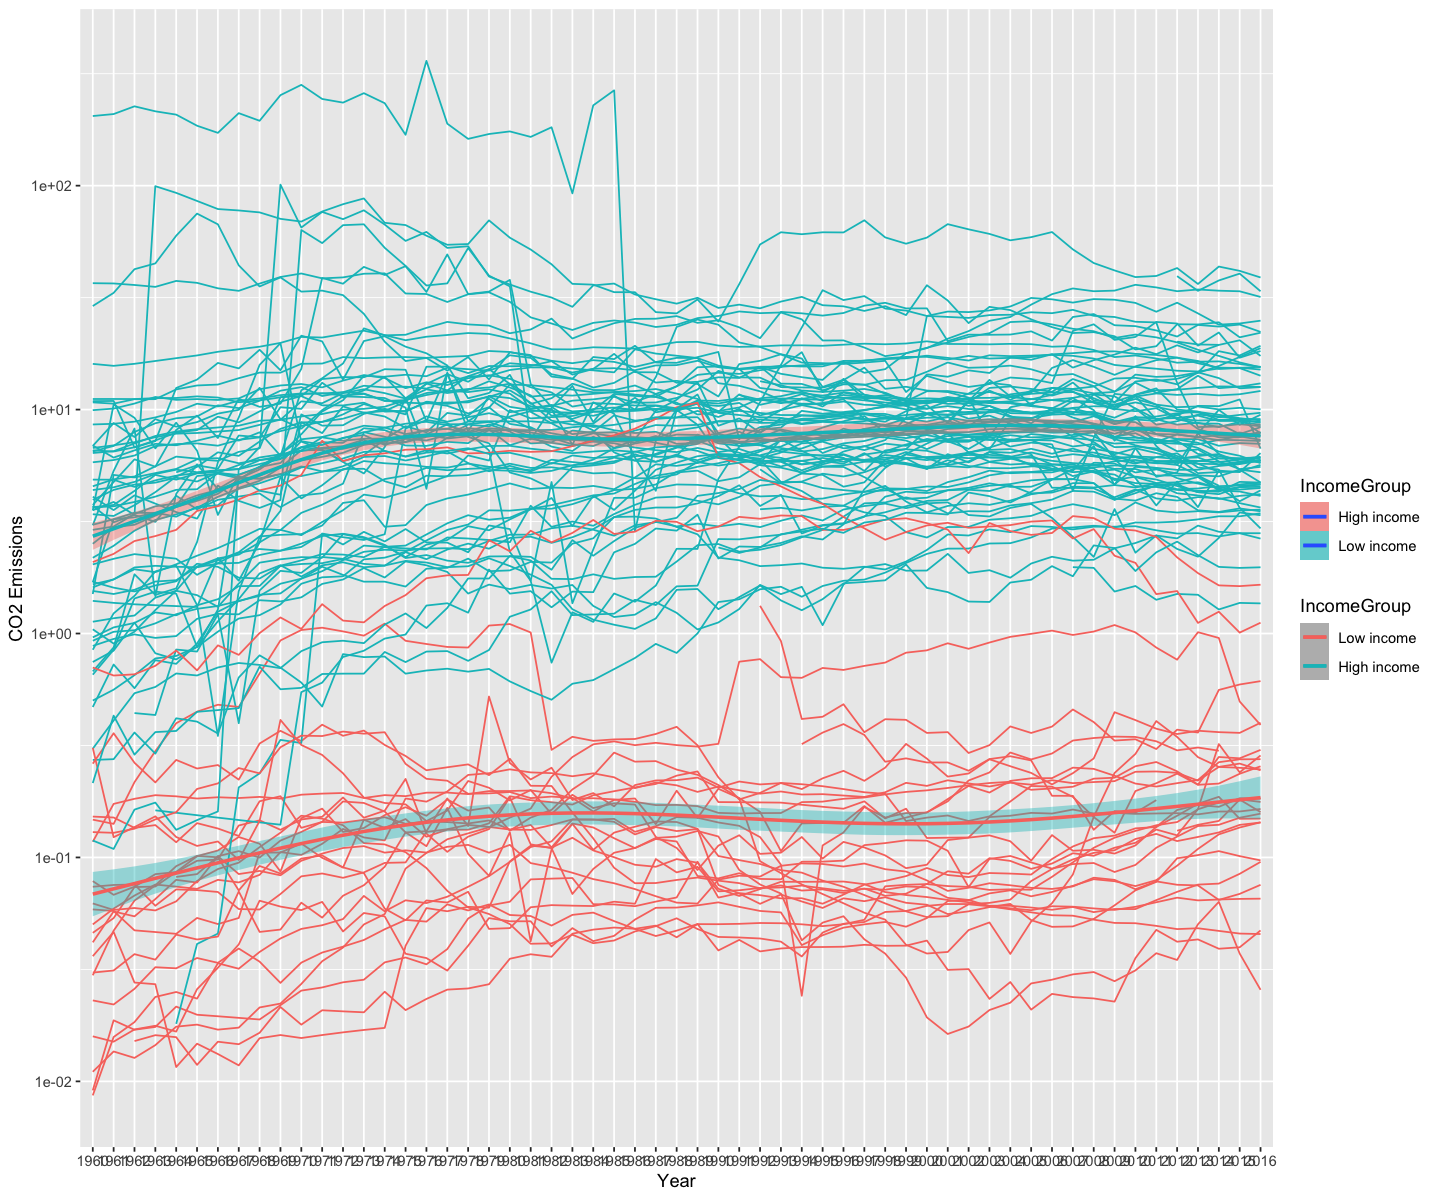

In [83]:
options(repr.plot.width = 12, repr.plot.height = 10)
ggplot() + 
  geom_line(data = global_emissions_df %>%
      filter(`Country Code` %!in% all_regional_groups & IncomeGroup == 'Low income' | IncomeGroup == 'High income'), 
            aes(x = Year, y = `CO2 Emissions`, group = `Country Name`, color = IncomeGroup)) + 
  geom_smooth(data = global_emissions_df %>%
      filter(`Country Code` %!in% all_regional_groups & IncomeGroup == 'Low income'), 
            aes(x = Year, y = `CO2 Emissions`, group = 1, color = IncomeGroup, fill = IncomeGroup)) +
  geom_smooth(data = global_emissions_df %>%
      filter(`Country Code` %!in% all_regional_groups & IncomeGroup == 'High income'), 
            aes(x = Year, y = `CO2 Emissions`, group = 1, color = IncomeGroup, fill = IncomeGroup)) +
  scale_y_log10() #+ 

  #facet_wrap(~IncomeGroup, ncol = 1) 

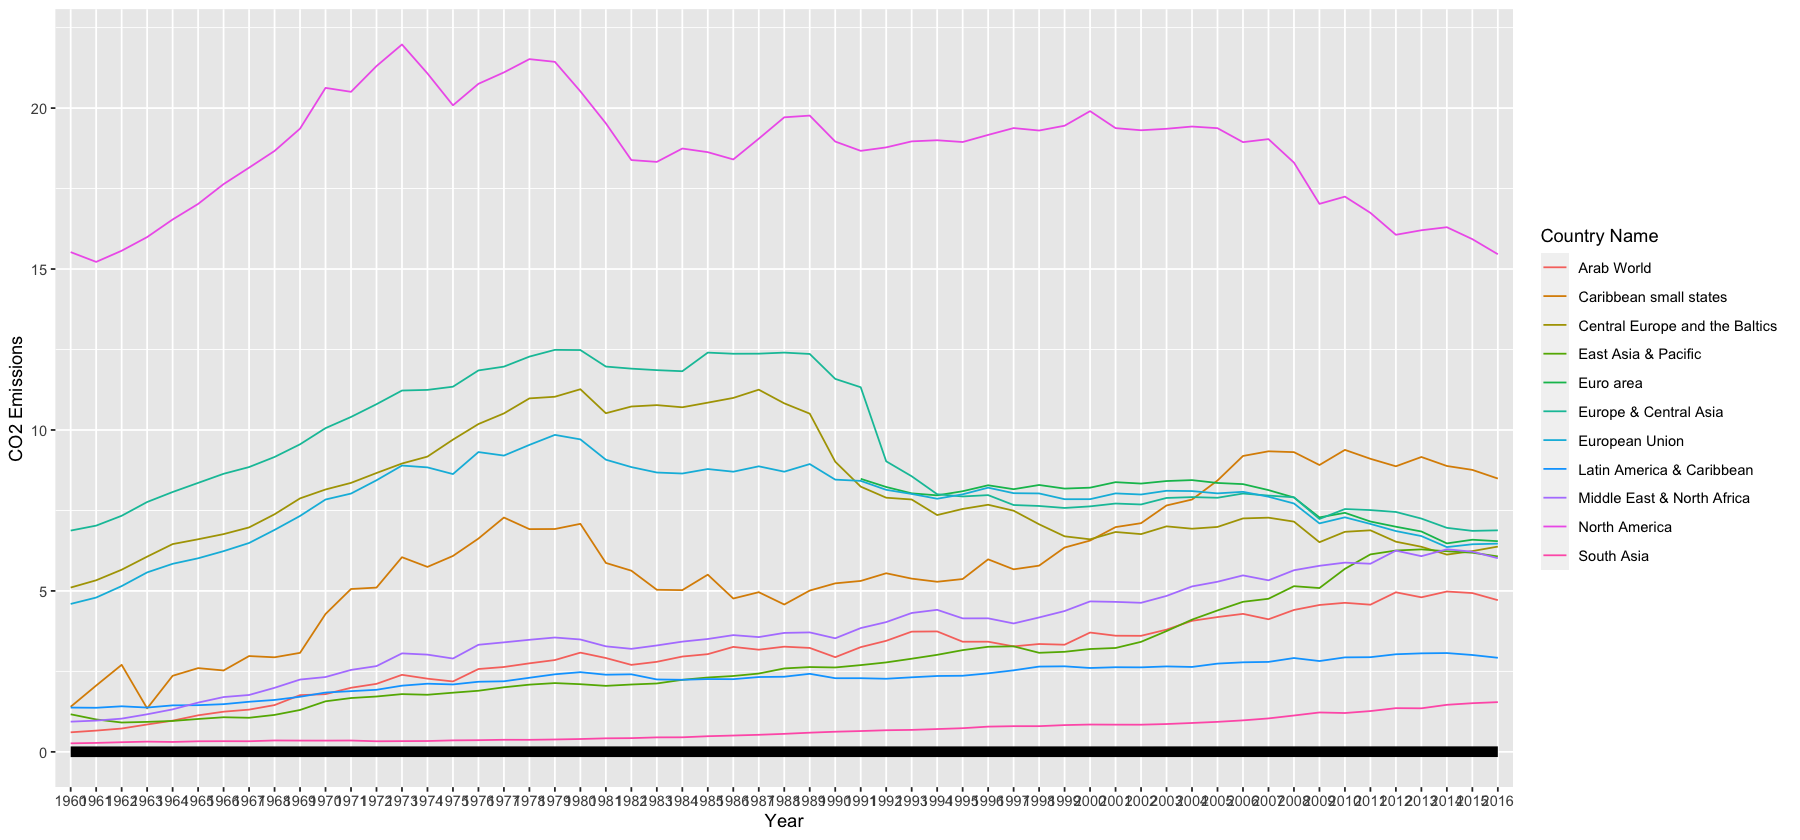

In [20]:
#plotting regional groups (includes the world as WLD)
regional_groups = c('ARB', "CEB", "CSS", "EAS", "ECS", "EMU", "EUU", "LCN", "MEA", "NAC", "SAS")

ggplot() + 
    geom_line(data = global_emissions_df %>%
     filter(`Country Code` %in% regional_groups), aes(x = Year, y = `CO2 Emissions`, group = `Country Name`, 
                                                      color = `Country Name`)) + 
    geom_line(data = global_emissions_df %>%
     filter(`Country Code` == "WLD"), aes(x = Year, y = `CO2 Emissions`, group = `Country Name`), size = 3)